In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [8]:
df = pd.read_csv('/GermanCredit.csv')

df.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,... < 100 DM,6,critical account/other credits existing,domestic appliances,1169,unknown/no savings account,... >= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee/official,1,yes,yes,1
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee/official,1,no,yes,0
2,no checking account,12,critical account/other credits existing,retraining,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,no,yes,1
3,... < 100 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,building society savings agreement/life insurance,45,none,for free,1,skilled employee/official,2,no,yes,1
4,... < 100 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,...,unknown/no property,53,none,for free,2,skilled employee/official,2,no,yes,0


In [10]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [12]:
for col in categorical_cols:
    print(f"\n▶ {col} ({df[col].nunique()} categories):")
    print(df[col].value_counts())


▶ status (4 categories):
no checking account                           394
... < 100 DM                                  274
0 <= ... < 200 DM                             269
... >= 200 DM / salary for at least 1 year     63
Name: status, dtype: int64

▶ credit_history (5 categories):
existing credits paid back duly till now       530
critical account/other credits existing        293
delay in paying off in the past                 88
all credits at this bank paid back duly         49
no credits taken/all credits paid back duly     40
Name: credit_history, dtype: int64

▶ purpose (10 categories):
domestic appliances    280
car (new)              234
radio/television       181
car (used)             103
others                  97
retraining              50
education               22
repairs                 12
furniture/equipment     12
business                 9
Name: purpose, dtype: int64

▶ savings (5 categories):
... < 100 DM                  603
unknown/no savings account    183
10

In [14]:
def split_personal_status(value):
    if value.startswith('male'):
        sex = 'male'
    else:
        sex = 'female'
    
    status = value.split(":")[-1].strip()
    return pd.Series([sex, status])

# Apply and replace
df[['Sex', 'Personal_Status']] = df['personal_status_sex'].apply(split_personal_status)

# Drop the original column
df.drop(columns='personal_status_sex', inplace=True)

In [16]:
df['foreign_worker'] = df['foreign_worker'].map({'yes': 1, 'no': 0})

# Map 'telephone' to binary: yes → 1, no → 0
df['telephone'] = df['telephone'].map({'yes': 1, 'no': 0})

In [18]:
df.drop(columns='Personal_Status', inplace=True)

In [20]:
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

In [22]:
exclude_cols = ['people_liable', 'telephone', 'foreign_worker', 'credit_risk', 'Sex']

In [24]:
numerical_cols_for_outliers = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols_for_outliers = [col for col in numerical_cols_for_outliers if col not in exclude_cols]

# Function to cap outliers using IQR
def cap_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Apply capping only to the valid features
for col in numerical_cols_for_outliers:
    cap_outliers_iqr(df, col)

In [26]:
status_mapping = {
    "... < 100 DM": "lt_100",
    "0 <= ... < 200 DM": "btw_0_200",
    "... >= 200 DM / salary for at least 1 year": "gte_200_salary",
    "no checking account": "no_account"  # if this value exists in the dataset
}

credit_history_mapping = {
    "existing credits paid back duly till now": "paid_duly",
    "critical account/other credits existing": "critical_account",
    "delay in paying off in the past": "delayed_payment",
    "all credits at this bank paid back duly": "bank_paid_duly",
    "no credits taken/all credits paid back duly": "no_credits"
}

# PURPOSE
purpose_mapping = {
    "domestic appliances": "domestic_appliances",
    "car (new)": "new_car",
    "radio/television": "radio_tv",
    "car (used)": "used_car",
    "others": "others",
    "retraining": "retraining",
    "education": "education",
    "repairs": "repairs",
    "furniture/equipment": "furniture",
    "business": "business"
}

# SAVINGS
savings_mapping = {
    "... < 100 DM": "lt_100",
    "unknown/no savings account": "no_savings",
    "100 <= ... < 500 DM": "btw_100_500",
    "500 <= ... < 1000 DM": "btw_500_1000",
    "... >= 1000 DM": "gte_1000"
}

# EMPLOYMENT DURATION
employment_mapping = {
    "1 <= ... < 4 years": "1_to_4_yrs",
    "... >= 7 years": "gte_7_yrs",
    "4 <= ... < 7 years": "4_to_7_yrs",
    "... < 1 year": "lt_1_yr",
    "unemployed": "unemployed"
}

# OTHER DEBTORS / GUARANTORS
other_debtors_mapping = {
    "none": "none",
    "guarantor": "guarantor",
    "co-applicant": "co_applicant"
}

# PROPERTY
property_mapping = {
    "car or other": "car_other",
    "real estate": "real_estate",
    "building society savings agreement/life insurance": "savings_insurance",
    "unknown/no property": "no_property"
}

# OTHER INSTALLMENT PLANS
installment_plans_mapping = {
    "none": "none",
    "bank": "bank",
    "stores": "stores"
}

# HOUSING
housing_mapping = {
    "own": "own",
    "rent": "rent",
    "for free": "free"
}

# JOB
job_mapping = {
    "skilled employee/official": "skilled",
    "unskilled - resident": "unskilled_resident",
    "management/self-employed/highly qualified employee/officer": "management",
    "unemployed/unskilled - non-resident": "unskilled_nonresident"
}

In [28]:
df['credit_history'] = df['credit_history'].map(credit_history_mapping)
df['purpose'] = df['purpose'].map(purpose_mapping)
df['savings'] = df['savings'].map(savings_mapping)
df['employment_duration'] = df['employment_duration'].map(employment_mapping)
df['other_debtors'] = df['other_debtors'].map(other_debtors_mapping)
df['property'] = df['property'].map(property_mapping)
df['other_installment_plans'] = df['other_installment_plans'].map(installment_plans_mapping)
df['housing'] = df['housing'].map(housing_mapping)
df['job'] = df['job'].map(job_mapping)

In [30]:
X = df.drop(columns='credit_risk')
y = df['credit_risk']

In [32]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [34]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test_original = X_test.copy() 

In [38]:
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])


In [40]:
exclude_scaling = ['people_liable', 'telephone', 'foreign_worker', 'Sex']

# Get all numerical columns from the dataset
all_numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Filter to get only the columns you DO want to scale
numerical_to_scale = [col for col in all_numerical_cols if col not in exclude_scaling]

# Initialize and apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_to_scale])
X_test_scaled = scaler.transform(X_test[numerical_to_scale])

In [42]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_to_scale, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_to_scale, index=X_test.index)

In [44]:
X_train_unscaled_df = X_train[exclude_scaling].copy()
X_test_unscaled_df = X_test[exclude_scaling].copy()

# 3. Create DataFrames for encoded categorical features
encoded_cat_features = encoder.get_feature_names_out(categorical_cols)

X_train_cat_df = pd.DataFrame(X_train_cat, columns=encoded_cat_features, index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=encoded_cat_features, index=X_test.index)

In [46]:
X_train_final = pd.concat([X_train_scaled_df, X_train_unscaled_df, X_train_cat_df], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test_unscaled_df, X_test_cat_df], axis=1)

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TabularDataset(Dataset):
    def __init__(self, X, y):
        # Accept pandas DataFrame/Series or numpy arrays
        self.X = torch.tensor(X.values if hasattr(X, 'values') else X,
                              dtype=torch.float32)
        self.y = torch.tensor(y.values if hasattr(y, 'values') else y,
                              dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [50]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, embed_dim=64, hidden_dim=128,
                 num_layers=2, dropout=0.1, rnn_type='LSTM'):
        super().__init__()
        self.input_dim = input_dim
        # embed each scalar feature into a vector of size embed_dim
        self.embedding  = nn.Linear(1, embed_dim)
        # choose RNN type
        rnn_type = rnn_type.upper()
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers,
                               batch_first=True, dropout=dropout)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers,
                              batch_first=True, dropout=dropout)
        else:
            raise ValueError("rnn_type must be 'LSTM' or 'GRU'")
        # final classification head
        self.classifier = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [batch_size, input_dim]
        x = x.unsqueeze(-1)            # -> [batch, input_dim, 1]
        x = self.embedding(x)          # -> [batch, input_dim, embed_dim]
        output, hidden = self.rnn(x)   # output: [batch, input_dim, hidden_dim]
        # hidden: (h_n, c_n) for LSTM or h_n for GRU
        if isinstance(hidden, tuple):  # LSTM
            h_n = hidden[0]
        else:                          # GRU
            h_n = hidden
        # h_n: [num_layers, batch, hidden_dim]
        last_h = h_n[-1]               # -> [batch, hidden_dim]
        logits = self.classifier(last_h).squeeze(1)  # -> [batch]
        return logits

In [52]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    return running_loss / len(loader.dataset)


def evaluate_and_collect(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            logits = model(Xb)
            preds = (torch.sigmoid(logits) > 0.5).long().cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.numpy().astype(int))
    return y_true, y_pred

In [54]:
train_ds = TabularDataset(X_train_final, y_train)
test_ds  = TabularDataset(X_test_final,  y_test)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64)

model     = RNNClassifier(input_dim=X_train.shape[1], rnn_type='LSTM').to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20
for ep in range(1, epochs+1):
    loss = train_one_epoch(model, train_loader, criterion, optimizer)
    print(f"Epoch {ep}/{epochs} — Loss: {loss:.4f}")


Epoch 1/20 — Loss: 0.6251
Epoch 2/20 — Loss: 0.6130
Epoch 3/20 — Loss: 0.6140
Epoch 4/20 — Loss: 0.6145
Epoch 5/20 — Loss: 0.6118
Epoch 6/20 — Loss: 0.6117
Epoch 7/20 — Loss: 0.6127
Epoch 8/20 — Loss: 0.6126
Epoch 9/20 — Loss: 0.6122
Epoch 10/20 — Loss: 0.6101
Epoch 11/20 — Loss: 0.6089
Epoch 12/20 — Loss: 0.6076
Epoch 13/20 — Loss: 0.6067
Epoch 14/20 — Loss: 0.5943
Epoch 15/20 — Loss: 0.6210
Epoch 16/20 — Loss: 0.6080
Epoch 17/20 — Loss: 0.6070
Epoch 18/20 — Loss: 0.6038
Epoch 19/20 — Loss: 0.5932
Epoch 20/20 — Loss: 0.5892


In [71]:
# epochs = 200
# for epoch in range(1, epochs+1):
#     train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
#     print(f"Epoch {epoch}/{epochs} — Loss: {train_loss:.4f}")

In [56]:
y_true, y_pred = evaluate_and_collect(model, test_loader)


In [58]:
y_true, y_pred = evaluate_and_collect(model, test_loader)

In [60]:


# 4) Save predictions in a DataFrame
predictions_df = pd.DataFrame({'prediction': y_pred})
print("\nSample of predictions DataFrame:")
print(predictions_df.head())



Sample of predictions DataFrame:
   prediction
0           1
1           1
2           1
3           1
4           1


In [60]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6850


In [62]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.03      0.06        60
           1       0.70      0.96      0.81       140

    accuracy                           0.69       200
   macro avg       0.49      0.50      0.44       200
weighted avg       0.58      0.69      0.59       200


Confusion Matrix:
 [[  2  58]
 [  5 135]]


In [66]:
tmp = X_test_original.copy()
tmp['prediction'] = y_pred
predictions_df = tmp


In [68]:
predictions_df

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,other_debtors,present_residence,...,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,Sex,prediction
977,0 <= ... < 200 DM,18,delayed_payment,others,2427.000,no_savings,gte_7_yrs,4,none,2,...,42.0,none,own,2.0,skilled,1,0,1,1,1
735,0 <= ... < 200 DM,36,bank_paid_duly,repairs,3990.000,no_savings,lt_1_yr,3,none,2,...,29.0,bank,own,1.0,unskilled_nonresident,1,0,1,0,1
615,0 <= ... < 200 DM,42,no_credits,others,7882.375,no_savings,1_to_4_yrs,2,none,2,...,48.0,bank,own,1.0,management,1,1,1,1,1
413,no checking account,10,paid_duly,new_car,1597.000,btw_500_1000,1_to_4_yrs,3,none,2,...,40.0,none,rent,1.0,unskilled_resident,2,0,0,1,1
563,0 <= ... < 200 DM,36,paid_duly,new_car,7882.375,no_savings,1_to_4_yrs,1,none,4,...,37.0,none,free,1.0,skilled,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0 <= ... < 200 DM,15,critical_account,domestic_appliances,2728.000,no_savings,4_to_7_yrs,4,guarantor,2,...,35.0,bank,own,3.0,skilled,1,1,1,1,1
442,0 <= ... < 200 DM,20,delayed_payment,furniture,2629.000,lt_100,1_to_4_yrs,2,none,3,...,29.0,bank,own,2.0,skilled,1,1,1,1,1
153,0 <= ... < 200 DM,24,critical_account,used_car,7758.000,gte_1000,gte_7_yrs,2,none,4,...,29.0,none,rent,1.0,skilled,1,0,1,0,1
325,... < 100 DM,8,critical_account,new_car,3398.000,lt_100,4_to_7_yrs,1,none,4,...,39.0,none,own,2.0,unskilled_resident,1,0,0,1,1


In [100]:
import pandas as pd
import numpy as np
# from scipy.stats import f_oneway, pearsonr
import matplotlib.pyplot as plt

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, chi2_contingency

In [114]:
categorical_features = ["status",
 "credit_history",
 "purpose",
 'savings',
 "employment_duration",
 "other_debtors",
 "property",
 "other_installment_plans",
 "housing",
 "job"]

In [116]:
target = "prediction"

In [118]:
numeric_features = [c for c in predictions_df.columns 
    if c not in categorical_features and c != target]

In [120]:
def cramers_v(conf_mat):
    chi2, _, _, _ = chi2_contingency(conf_mat)
    n = conf_mat.values.sum()
    r, k = conf_mat.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

In [122]:
records = []

In [124]:
for feat in numeric_features:
    r, p = pointbiserialr(predictions_df[feat], predictions_df[target])
    if p < 0.05:
        records.append({'Feature': feat,
                'Type': 'Numeric',
                'p_value': p,
                'effect_size': abs(r)
            })

for feat in categorical_features:
    conf = pd.crosstab(predictions_df[feat], predictions_df[target])
    chi2_stat, p, _, _ = chi2_contingency(conf)
    if p < 0.05:
        v = cramers_v(conf)
        records.append({'Feature': feat,
                'Type': 'Categorical',
                'p_value': p,
                'effect_size': v
            })

In [126]:
if not records:
    print("No features reached p < 0.05.")
else:
    eff_df = pd.DataFrame(records)
    eff_df = eff_df.sort_values('effect_size', ascending=False).reset_index(drop=True)
    
    # 5. Display ranked features
    display(eff_df[['Feature', 'Type', 'p_value', 'effect_size']])

,Feature,Type,p_value,effect_size
0,employment_duration,Categorical,0.001985,0.291040
1,housing,Categorical,0.000721,0.268971
2,property,Categorical,0.012526,0.232989
3,status,Categorical,0.012717,0.232636
4,age,Numeric,0.030729,0.152835


In [70]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import pointbiserialr, chi2_contingency, chi2
from sklearn.impute import SimpleImputer
import statsmodels.formula.api as smf
from scipy.special import expit
from IPython.display import display

In [76]:
categorical_features = ["status",
 "credit_history",
 "purpose",
 'savings',
 "employment_duration",
 "other_debtors",
 "property",
 "other_installment_plans",
 "housing",
 "job"]

target = "prediction"

numeric_features = ['duration',
 'amount',
 'installment_rate',
 'present_residence',
 'age',
 'number_credits',
 'people_liable',
 'telephone',
 'foreign_worker',
 'Sex']

alpha = 0.05

In [82]:
import numpy as np
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.impute import SimpleImputer
from IPython.display import display

# 1) Main‐effect ranking
def compute_main_importance(df, numeric_feats, categorical_feats, target, alpha=0.05):
    df = df.copy()
    for c in categorical_feats:
        df[c] = df[c].astype('category')
    def cramers_v(tbl):
        chi2_stat = chi2_contingency(tbl, correction=False)[0]
        n = tbl.values.sum(); r, k = tbl.shape
        return np.sqrt(chi2_stat / (n * (min(r, k) - 1)))
    rows = []
    for feat in numeric_feats:
        r, p = pointbiserialr(df[feat], df[target])
        eff = abs(r) if p < alpha else 0.0
        rows.append({'Feature': feat, 'p_value': round(p,4), 'Effect': round(eff,4)})
    for feat in categorical_feats:
        tbl = pd.crosstab(df[feat], df[target])
        _, p, _, _ = chi2_contingency(tbl, correction=False)
        eff = cramers_v(tbl) if p < alpha else 0.0
        rows.append({'Feature': feat, 'p_value': round(p,4), 'Effect': round(eff,4)})
    return pd.DataFrame(rows).sort_values('Effect', ascending=False).reset_index(drop=True)

def perturb_with_noise(df, numeric_features, categorical_features, 
                       gaussian_frac=0.01, cat_noise_frac=0.05):
    pert = df.copy()
    # Gaussian noise on numerics
    for c in numeric_features:
        sigma = gaussian_frac * pert[c].std()
        pert[c] += np.random.normal(0, sigma, size=len(pert))
    # Mis-label a fraction of categoricals
    for c in categorical_features:
        mask = np.random.rand(len(pert)) < cat_noise_frac
        if mask.any():
            levels = pert[c].dropna().unique()
            pert.loc[mask, c] = np.random.choice(levels, size=mask.sum())
    return pert



# 2) Single‐run Jaccard@Top-5
def compute_single_jaccard_top5(df, num_feats, cat_feats, target, alpha=0.05):
    orig = compute_main_importance(df, num_feats, cat_feats, target, alpha)['Feature'][:5].tolist()
    pert = df.copy()
    # noise + MCAR
    for c in num_feats:
        pert[c] += np.random.normal(0, 0.01*pert[c].std(), size=len(pert))
    frac = np.random.uniform(0.05,0.10)
    idx = pert.sample(frac=frac).index
    pert.loc[idx, num_feats]     = np.nan
    idx = pert.sample(frac=frac).index
    pert.loc[idx, cat_feats]     = np.nan
    pert[num_feats] = SimpleImputer(strategy='mean').fit_transform(pert[num_feats])
    pert[cat_feats] = SimpleImputer(strategy='most_frequent').fit_transform(pert[cat_feats])
    new = compute_main_importance(pert, num_feats, cat_feats, target, alpha)['Feature'][:5].tolist()

    j = len(set(orig)&set(new))/len(set(orig)|set(new))
    return j, orig, new

def evaluate_jaccard_topk_noise(df, numeric_features, categorical_features, target,
                                n_runs=50, top_k=5, alpha=0.05,
                                gaussian_frac=0.01, cat_noise_frac=0.05):
    orig = compute_main_importance(df, numeric_features, categorical_features, target, alpha)['Feature'][:top_k].tolist()
    orig_set = set(orig)
    scores = []
    for _ in range(n_runs):
        pert = perturb_with_noise(df, numeric_features, categorical_features, gaussian_frac, cat_noise_frac)
        new = compute_main_importance(pert, numeric_features, categorical_features, target, alpha)['Feature'][:top_k].tolist()
        scores.append(len(orig_set & set(new)) / len(orig_set | set(new)) if orig_set else 0.0)
    return {
        f'avg_jaccard_top_{top_k}': np.mean(scores),
        f'std_jaccard_top_{top_k}': np.std(scores)
    }

# === RUN THIS AFTER merged_df IS DEFINED ===
# numeric_features = ['age', 'fnlwgt', 'hours_per_week']
# categorical_features = ["workclass", "education", "marital-status","occupation","relationship","race","gender","native-country"]
# target = 'Predicted_Label'
# alpha = 0.05

# show main‐effect ranking
main_df = compute_main_importance(predictions_df, numeric_features, categorical_features, target, alpha)
display(main_df)

# compute one‐off Jaccard@5
j, orig_top5, pert_top5 = compute_single_jaccard_top5(
    predictions_df, numeric_features, categorical_features, target, alpha
)
print("Original Top-5:", orig_top5)
print("Perturbed Top-5:", pert_top5)
print(f"Jaccard@Top-5 = {j:.2f}")

# Average over 50 runs
stability = evaluate_jaccard_topk_noise(
    predictions_df, numeric_features, categorical_features, target,
    n_runs=50, top_k=5, alpha=alpha,
    gaussian_frac=0.01, cat_noise_frac=0.05
)
print("\nNoise-only stability:", stability)


,Feature,p_value,Effect
0,other_installment_plans,0.0000,0.3818
1,purpose,0.0058,0.3403
2,job,0.0018,0.2743
3,credit_history,0.0071,0.2650
4,other_debtors,0.0096,0.2156
5,amount,0.3334,0.0000
6,housing,0.6438,0.0000
7,property,0.3386,0.0000
8,employment_duration,0.4981,0.0000
9,savings,0.2044,0.0000


Original Top-5: ['other_installment_plans', 'purpose', 'job', 'credit_history', 'other_debtors']
Perturbed Top-5: ['other_installment_plans', 'purpose', 'job', 'credit_history', 'other_debtors']
Jaccard@Top-5 = 1.00

Noise-only stability: {'avg_jaccard_top_5': 0.8371428571428571, 'std_jaccard_top_5': 0.18222360488386447}


In [84]:
import os
save_dir = r"/Users/arsh/real_STAT"           # ← Windows example
# save_dir = "/Users/alice/Pictures/MyPlots"            # ← macOS/Linux example

# 2) Make sure it exists
os.makedirs(save_dir, exist_ok=True)

# 3) Build the full filename
filename = "RNN_German.jpg"
output_path = os.path.join(save_dir, filename)

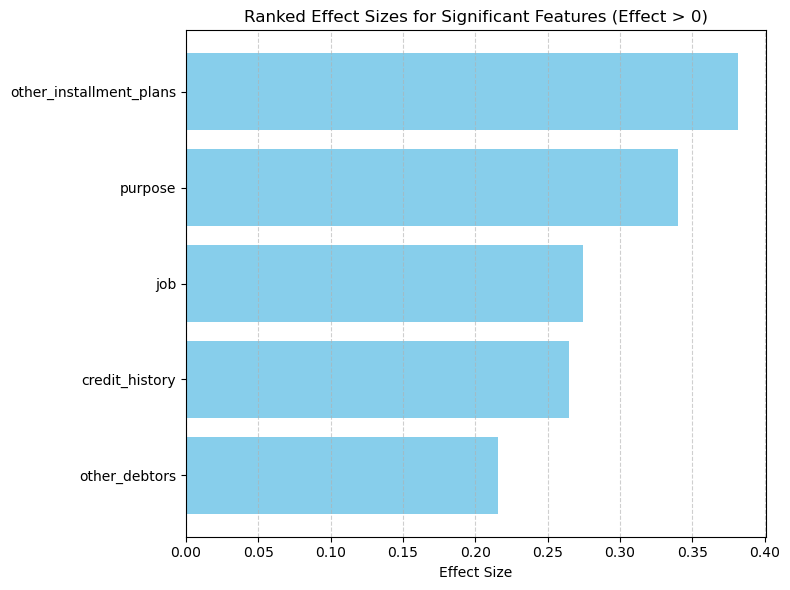

Saved plot to: /Users/arsh/real_STAT/RNN_German.jpg


In [86]:
import matplotlib.pyplot as plt

plot_df = main_df[main_df['Effect'] > 0]

plt.figure(figsize=(8, 6))
plt.barh(plot_df['Feature'], plot_df['Effect'], color='skyblue')
plt.xlabel("Effect Size")
plt.title("Ranked Effect Sizes for Significant Features (Effect > 0)")
plt.gca().invert_yaxis()  # largest effect at top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()

print("Saved plot to:", os.path.abspath(output_path))